# Classification Practice

In [1]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# I made something for y'all

def eval_classification(model, model_name,
                        X_tr, X_te, y_tr, y_te,
                        to_print=False):
    '''
    Finds predictions for train and test sets, then
    prints metrics for classification nicely

    Inputs:
    model : already-fit sklearn model
    model_name : string, name for index for output df
    X_tr : training X (can be scaled, that's fine)
    X_te : testing X
    y_tr : training target
    y_te : testing target
    to_print : boolean, will print output nicely if True

    Outputs:
    metric_df - pandas Dataframe showing output
    '''
    
    metrics = {"Accuracy": accuracy_score,
               "Recall": recall_score,
               "Precision": precision_score,
               "F1-Score": f1_score}

    y_pred_tr = model.predict(X_tr)
    y_pred_te = model.predict(X_te)

    # Defining the column names based on the metric dict keys
    col_list = []  # Starting a list
    for name in metrics.keys():
        col_list.append(f"{name.lower()}_train")
        col_list.append(f"{name.lower()}_test")

    metric_df = pd.DataFrame(columns=col_list)

    for name, metric_function in metrics.items():
        tr_col = f"{name.lower()}_train"
        metric_df.at[model_name, tr_col] = metric_function(y_tr, y_pred_tr)
        te_col = f"{name.lower()}_test"
        metric_df.at[model_name, te_col] = metric_function(y_te, y_pred_te)
        
        # Adding to-print option to print the metrics nicely
        if to_print:
            print(f"{name}:"); print("="*len(name))
            print(f"TRAIN: {metric_function(y_tr, y_pred_tr):.4f}")
            print(f"TEST: {metric_function(y_te, y_pred_te):.4f}")
            print("*" * 15)
    
    return metric_df

In [3]:
# Data import
df = pd.read_csv('data/baseball_height_weight.csv')

In [4]:
df.head()

,name,team,position,height_in,weight_lb,age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


In [5]:
df['position'].value_counts()

Relief_Pitcher       314
Starting_Pitcher     220
Outfielder           194
Catcher               76
Second_Baseman        58
First_Baseman         55
Shortstop             52
Third_Baseman         45
Designated_Hitter     18
Name: position, dtype: int64

## Problem Definition

I'm curious whether there are definitive differences between types of baseball players in terms of their physical attributes. Let's see if we can define a model that can predict whether a player is a pitcher or not.

In [6]:
# Defining our target
df['pitcher'] = np.where(df['position'].str.contains("_Pitcher", case=False, na=False), 1, 0)

In [7]:
df['pitcher'].value_counts()

1    534
0    498
Name: pitcher, dtype: int64

In [8]:
# baseline accuracy (if we always predicted pitcher)

len(df[df['pitcher'] == 1]) / len(df)

0.5174418604651163

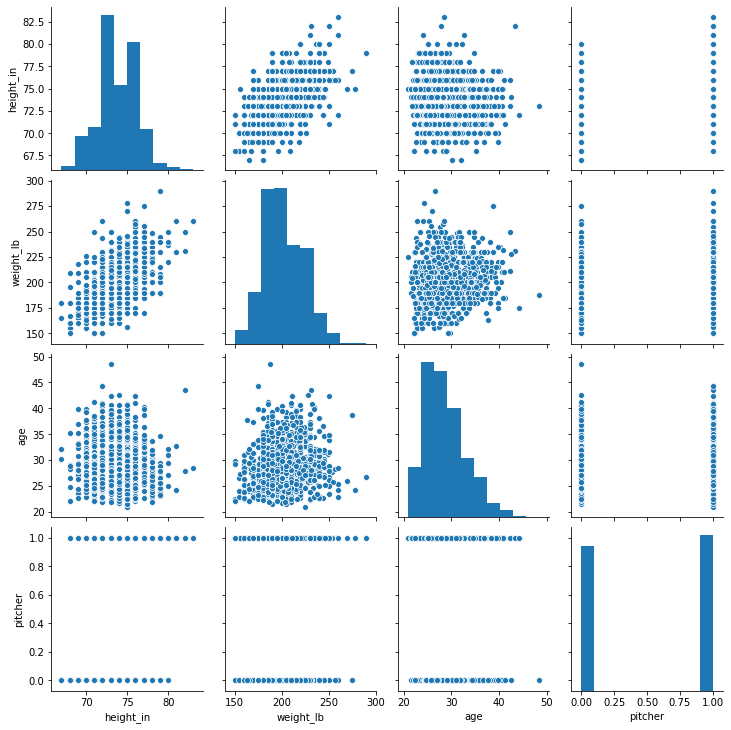

In [9]:
sns.pairplot(df)

## Modeling

#### Model 1: Vanilla Logistic Regression

In [10]:
# Defining our X and y
X = df[['height_in', 'weight_lb', 'age']]
y = df['pitcher']

In [11]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [12]:
# Scaling our data
scaler = StandardScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [13]:
# Instantiating and fitting our first model
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)

LogisticRegression()

In [14]:
# Using our predefined function
logreg_scores = eval_classification(logreg, "logreg",
                                    X_train_sc, X_test_sc,
                                    y_train, y_test,
                                    to_print=True)

Accuracy:
TRAIN: 0.6498
TEST: 0.6481
***************
Recall:
TRAIN: 0.6919
TEST: 0.6723
***************
Precision:
TRAIN: 0.6517
TEST: 0.6575
***************
F1-Score:
TRAIN: 0.6712
TEST: 0.6648
***************


In [15]:
logreg_scores

,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1-score_train,f1-score_test
logreg,0.649783,0.648094,0.691877,0.672316,0.651715,0.657459,0.671196,0.664804


#### Model 2: Balanced Logistic Regression

In [16]:
logreg_2 = LogisticRegression(class_weight='balanced')
logreg_2.fit(X_train_sc, y_train)

LogisticRegression(class_weight='balanced')

In [17]:
logreg_bal = eval_classification(logreg_2, "logreg_bal", 
                                 X_train_sc, X_test_sc, 
                                 y_train, y_test,
                                 to_print=True)

Accuracy:
TRAIN: 0.6585
TEST: 0.6422
***************
Recall:
TRAIN: 0.6555
TEST: 0.6384
***************
Precision:
TRAIN: 0.6744
TEST: 0.6608
***************
F1-Score:
TRAIN: 0.6648
TEST: 0.6494
***************


In [18]:
# Now, because we have these as dataframes with the same colnames:
metrics = pd.concat([logreg_scores, logreg_bal])
metrics

,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1-score_train,f1-score_test
logreg,0.649783,0.648094,0.691877,0.672316,0.651715,0.657459,0.671196,0.664804
logreg_bal,0.658466,0.642229,0.655462,0.638418,0.674352,0.660819,0.664773,0.649425


#### Model 3: KNN with K=3

In [21]:
# Instantiate and fit your model

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_sc, y_train)

KNeighborsClassifier(n_neighbors=3)

In [22]:
# Evaluate

knn_results = eval_classification(knn, "knn_default", 
                                 X_train_sc, X_test_sc, 
                                 y_train, y_test,
                                 to_print=True)

Accuracy:
TRAIN: 0.7931
TEST: 0.6510
***************
Recall:
TRAIN: 0.8011
TEST: 0.6723
***************
Precision:
TRAIN: 0.7989
TEST: 0.6611
***************
F1-Score:
TRAIN: 0.8000
TEST: 0.6667
***************


In [23]:
knn_weight = KNeighborsClassifier(weights = 'distance')
knn_weight.fit(X_train_sc, y_train)

knn_w_results = eval_classification(knn_weight, "knn_dist", 
                                 X_train_sc, X_test_sc, 
                                 y_train, y_test,
                                 to_print=True)

Accuracy:
TRAIN: 0.9986
TEST: 0.6246
***************
Recall:
TRAIN: 0.9972
TEST: 0.6441
***************
Precision:
TRAIN: 1.0000
TEST: 0.6369
***************
F1-Score:
TRAIN: 0.9986
TEST: 0.6404
***************


In [24]:
# How can I compare KNN results to my earlier logreg?
for k in list(range(1, 11, 2)):
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_sc, y_train)
    knn_results = eval_classification(knn, f"knn{k}", 
                                 X_train_sc, X_test_sc, 
                                 y_train, y_test)
    metrics = pd.concat([metrics, knn_results])

In [25]:
metrics

,accuracy_train,accuracy_test,recall_train,recall_test,precision_train,precision_test,f1-score_train,f1-score_test
logreg,0.649783,0.648094,0.691877,0.672316,0.651715,0.657459,0.671196,0.664804
logreg_bal,0.658466,0.642229,0.655462,0.638418,0.674352,0.660819,0.664773,0.649425
knn1,0.998553,0.548387,0.997199,0.564972,1,0.564972,0.998597,0.564972
knn3,0.793054,0.651026,0.80112,0.672316,0.798883,0.661111,0.8,0.666667
knn5,0.771346,0.648094,0.756303,0.677966,0.791789,0.655738,0.773639,0.666667
knn7,0.767004,0.633431,0.7507,0.644068,0.788235,0.647727,0.76901,0.645892
knn9,0.748191,0.630499,0.739496,0.655367,0.765217,0.640884,0.752137,0.648045


## Evaluating

In [26]:
test_cols = [c for c in metrics.columns.to_list() if "test" in c]

In [27]:
metrics[test_cols]

,accuracy_test,recall_test,precision_test,f1-score_test
logreg,0.648094,0.672316,0.657459,0.664804
logreg_bal,0.642229,0.638418,0.660819,0.649425
knn1,0.548387,0.564972,0.564972,0.564972
knn3,0.651026,0.672316,0.661111,0.666667
knn5,0.648094,0.677966,0.655738,0.666667
knn7,0.633431,0.644068,0.647727,0.645892
knn9,0.630499,0.655367,0.640884,0.648045


# Level Up: Multi-Class Classification

In [28]:
from sklearn.datasets import load_iris

In [29]:
iris = load_iris()

In [30]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [31]:
X = iris['data']
y = iris['target']

In [32]:
iris_df = pd.DataFrame(X, columns = iris['feature_names'])
iris_df['target'] = y

In [34]:
iris['target_names']

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [33]:
iris_df.sample(n=10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
140,6.7,3.1,5.6,2.4,2
128,6.4,2.8,5.6,2.1,2
41,4.5,2.3,1.3,0.3,0
129,7.2,3.0,5.8,1.6,2
82,5.8,2.7,3.9,1.2,1
75,6.6,3.0,4.4,1.4,1
9,4.9,3.1,1.5,0.1,0
36,5.5,3.5,1.3,0.2,0
95,5.7,3.0,4.2,1.2,1
86,6.7,3.1,4.7,1.5,1


In [35]:
iris_df['target'].value_counts()

2    50
1    50
0    50
Name: target, dtype: int64

In [36]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## Modeling

In [37]:
# New train test split, now for iris data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42, stratify=y)

In [38]:
# Still need to scale
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [39]:
# Instantiate and fit a KNN classifier
knn = KNeighborsClassifier()
knn.fit(X_train_sc, y_train)

KNeighborsClassifier()

## Evaluating: How do we evaluate a multi-class model?

https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel

In [40]:
print(f"Train: {knn.score(X_train_sc, y_train)}")
print(f"Test: {knn.score(X_test_sc, y_test)}")

Train: 0.98
Test: 0.92


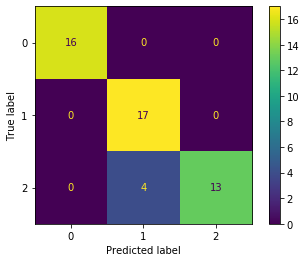

In [41]:
plot_confusion_matrix(knn, X_test_sc, y_test)